# Section III: Interacting With Hardware

In this notebook, you'll learn the pipeline for submitting a problem designed in *Bloqade* to real quantum hardware, and retrieving/analyzing the results.

The pipeline should be as follows:
* Define
* Emulate (if possible)
* Transform
* Validate
* Submit
* Retrieve

## Designing our Hamiltonian

From the `2_Rabi_and_ordered_phases` section of this repository you'll recall being exposed to the idea of ordered phases with neutral atom lattices, with each possible ordered phase achievable through properly fixing the lattice constant and choosing the right Rabi Frequency/final Detuning value when performing an Adiabatic Sweep (revisit the phase diagram in the document to get a refresher on this). We will use this as an example to learn how to deploy the pipeline mentioned above in a practical way.


So let's start by recreating the alternating pattern known as a "checkerboard" phase in large square atom arrays. For ease of simulation, here we will stick to a $3 \times 3$ atom lattice. Most of what follows is a revision of the process was illustrated in details on section `2_Rabi_and_ordered_phases`, but we take the opportunity to bring in a few more advanced comments.

Here is a script to set up the problem using atoms spaced by 6.7 $\mu m$ and a linear adiabatic protocol similar to what we learned in previous sections.

In [1]:
using Pkg

Pkg.activate("..")
Pkg.instantiate()

  Activating project at `~/GitHub/quera-education`


In [2]:
Pkg.status()

Status `~/GitHub/quera-education/Project.toml`
  [bd27d05e] Bloqade v0.1.24
  [6099a3de] PythonCall v0.9.13


In [3]:
using Bloqade

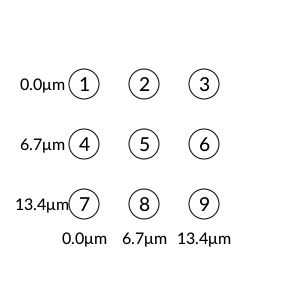

In [4]:
# define the distance between atoms
atom_distance = 6.7
# want a 3x3 Square Lattice with the atoms `atom_distance` apart
atoms = generate_sites(SquareLattice(), 3,3, scale = atom_distance)

In [5]:
# define our waveforms
# perform Adiabatic Sweep, where we keep a constant Rabi Frequency but slowly ramp the detuning from a large negative to large positive value
# Phase can be kept at 0

Ω_max = 2π * 2.5

Δ_val = 2π * 10.0

total_time = 3.0
time_ramp  = total_time * 0.083

clocks = [0, time_ramp, total_time - time_ramp, total_time]

Ω = piecewise_linear(clocks = clocks, values = [0.0, Ω_max, Ω_max, 0.0]); 
Δ = piecewise_linear(clocks = clocks, values = [-Δ_val, -Δ_val, Δ_val, Δ_val]);
ϕ = constant(;duration = total_time, value = 0.0);

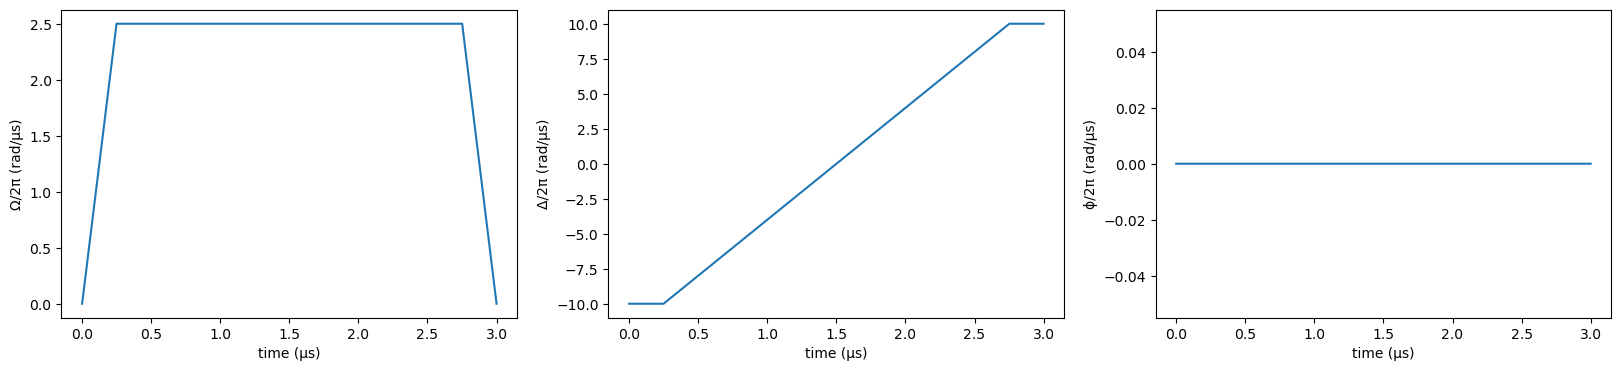

In [6]:
using PythonCall
plt = pyimport("matplotlib.pyplot");

fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize = (20, 4))
Bloqade.plot!(ax1, Ω)
ax1.set_ylabel("Ω/2π (rad/μs)")
Bloqade.plot!(ax2, Δ)
ax2.set_ylabel("Δ/2π (rad/μs)")
Bloqade.plot!(ax3, ϕ)
ax3.set_ylabel("ϕ/2π (rad/μs)")
fig

In [7]:
h = rydberg_h(atoms; Ω=Ω, Δ=Δ, ϕ=ϕ)

nqubits: 9
+
├─ [+] ∑ 2π ⋅ 8.627e5.0/|x_i-x_j|^6 n_i n_j
├─ [+] Ω(t) ⋅∑ e^{ϕ(t) ⋅ im} |0⟩⟨1| + e^{-ϕ(t) ⋅ im} |1⟩⟨0|
└─ [-] Δ(t) ⋅ ∑ n_i


The problem solution design is set, and we are ready for submitting to Aquila. But even if we are eager to run jobs on real quantum hardware, for sanity check and better spend resources, it's always a good idea (when possible) to emulate the evolution of the Hamiltonian and see if the end result agrees with expectation. 

Of course, emulation may not be possible if your system size is too large but you can take advantage of Bloqade's HPC facilities (check out section `5_HP_Bloqade` of the repo). Most laptops can handle Bloqade simulations with up to around 15 atoms.

As usual, the emulation starts by defining an empty register (you can think of this as our state vector)

In [8]:
reg = zero_state(9)

ArrayReg{2, ComplexF64, Array...}
    active qubits: 9/9
    nlevel: 2

Now we create a `SchrodingerProblem` instance which brings together our:
* `register`, for storing the results of emulation
* `total_time`, how long the time evolution should run for
* `h`, our Hamiltonian

Note that at this stage you can also take advantage of the different Differential Equation solvers provided by the `DifferentialEquations.jl` package and override Bloqade's default should you either have your own implementation that adheres to the `DifferentialEquations.jl` interface OR if you'd like to try a different auto-switching/Runge-Kutta solver.

In [9]:
total_time = 3.0
prob = SchrodingerProblem(reg, total_time, h)

SchrodingerProblem:
  register info:
    type: ArrayReg{2, ComplexF64, Matrix{ComplexF64}}
    storage size: 8 bytes

  time span (μs): (0.0, 3.0)

  equation: 
    storage size: 116.031 KiB
    expression:
nqubits: 9
+
├─ [+] ∑ 2π ⋅ 8.627e5.0/|x_i-x_j|^6 n_i n_j
├─ [+] Ω(t) ⋅∑ e^{ϕ(t) ⋅ im} |0⟩⟨1| + e^{-ϕ(t) ⋅ im} |1⟩⟨0|
└─ [-] Δ(t) ⋅ ∑ n_i


    algorithm: DP8(stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false))
  options:
    save_everystep: false
    save_start: false
    save_on: false
    dense: false
    reltol: 1.0e-10
    abstol: 1.0e-10


This `SchrodingerProblem` can then be passed to `emulate!`; while not the best method for analyzing ordered states, we will use Rydberg densities, through `rydberg_density`, for the sake of illustration of this tutorial

In [10]:
emulate!(prob);

In [11]:
rydberg_density(prob.reg)

9-element Vector{Float64}:
 0.9721146827662142
 0.01059366340315615
 0.9721146827662139
 0.01059366340315614
 0.9871480203026494
 0.010593663403156161
 0.9721146827662137
 0.010593663403156182
 0.9721146827662138

To extract something more visual, we use `bitstring_hist`:

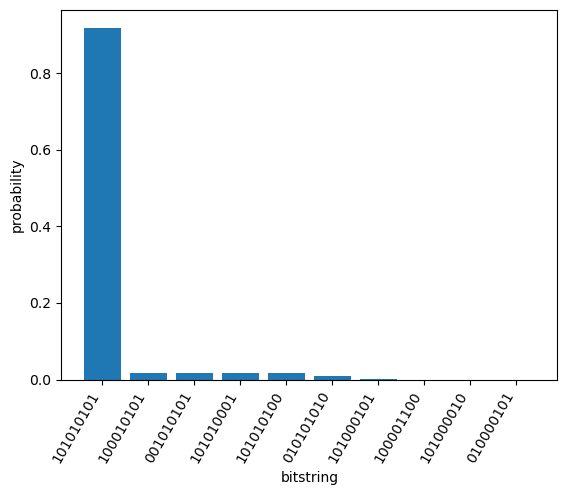

In [12]:
bitstring_hist(prob.reg; nlargest = 10)

and overlay the densities overlaid on the actual geometry. Bloqade defines a `plot_densities` function that uses a `bwr` (blue-white-red) colorscheme where blue is a Rydberg density of 0.0, white is 0.5, and red is 1.0

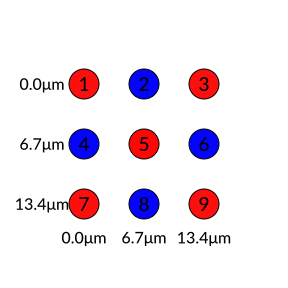

In [13]:
plot_densities(atoms, rydberg_density(prob.reg))

## Transform to Hardware

Access to QuEra's quantum hardware requires transforming the commands and definitions generated in Bloqade into formats that can be accepted by our machines. Why do we even *need* that?

Two points: firstly, access to our hardware is distributed in many ways, including our own internal services and, notably, AWS Braket. The variety of ways users submit jobs requires flexibility so we cannot be exclusively bound to Bloqade's internal innerworks. But secondly, and more importantly, quantum hardware is physical and have limitations of service. 

The lasers and other components of neutral atom hardware are limited in what they can pull off in terms of things such as the distance between atoms, certain waveform values, as well as time resolution. Many of these constraints are explored in detail on section `1__Basics`, but the bottom line is: algorithms designed on Bloqade may need to be adjusted to fit within the hardware capabilities. In cases adjusting is not possible at all, and changes are needed by the user.

So our first step in getting our problem to run on quantum hardware is to transform it into a shape that can be understood by the quantum hardware. All functions that deal with having to manipulate your problem into something that can run on hardware are contained in the `BloqadeSchema` package. `BloqadeSchema` is not directly a part of Bloqade, to reduce loading latencies, but can be added through: `using Pkg, Pkg.add("BloqadeSchema")`.

Fortunately the functions in `BloqadeSchema` that you'll be introduced to attempt to minimize and outright remove the need to keep this at the forefront of your mind when designing problems of interest. As you'll see below, the `hardware_transform` function will take your defined Hamiltonian and, with the hardware constraints in mind, produce a new Hamiltonian that is as minimally different from your original Hamiltonian while staying within hardware constraints.

In [16]:
using BloqadeSchema

`hardware_transform` returns two values: the actual transformed Hamiltonian and a `HardwareTransformInfo` object. This object is supposed to give you an idea of how much your original Hamiltonian had to be modified to generate a hardware compatible one.

In particular, the differences between the original and transformed Hamiltonians are characterized as follows:
* for atom positions, the _Mean Squared Error_ (`mse_atoms`) between the original and new atom positions is given
* for the Phase, Rabi Frequency, and Detuning, the differences are calculated as $||A - B||_1$ (ϕ_error, Ω_error, and, Δ_error), the one-norm difference 

(see the result of the `dump` function on `transform_info` below)

Ideally you'd like these values to be as small as possible, indicating there was not a major difference between your proposed and original Waveforms, but this may not always be the case.

In [17]:
transformed_h, transform_info = hardware_transform(h)

(nqubits: 9
+
├─ [+] ∑ 2π ⋅ 8.627e5.0/|x_i-x_j|^6 n_i n_j
├─ [+] Ω(t) ⋅∑ e^{ϕ(t) ⋅ im} |0⟩⟨1| + e^{-ϕ(t) ⋅ im} |1⟩⟨0|
└─ [-] Δ(t) ⋅ ∑ n_i
, BloqadeSchema.HardwareTransformInfo(0.0, 0.00010104987236779854, 1.2557095927972735e-7, (Δ = Waveform(_, 3.0), δ = nothing, Δi = 1.0), 0.0))

In [18]:
dump(transform_info)

BloqadeSchema.HardwareTransformInfo
  ϕ_error: Float64 0.0
  Ω_error: Float64 0.00010104987236779854
  Δ_error: Float64 1.2557095927972735e-7
  Δ_mask: NamedTuple{(

:Δ, :δ, :Δi), Tuple{Waveform{BloqadeWaveforms.PiecewiseLinear{Float64, Interpolations.Extrapolation{Float64, 1, Interpolations.GriddedInterpolation{Float64, 1, Float64, Interpolations.Gridded{Interpolations.Linear{Interpolations.Throw{Interpolations.OnGrid}}}, Tuple{Vector{Float64}}}, Interpolations.Gridded{Interpolations.Linear{Interpolations.Throw{Interpolations.OnGrid}}}, Interpolations.Throw{Nothing}}}, Float64}, Nothing, Float64}}
    Δ: Waveform{BloqadeWaveforms.PiecewiseLinear{Float64, Interpolations.Extrapolation{Float64, 1, Interpolations.GriddedInterpolation{Float64, 1, Float64, Interpolations.Gridded{Interpolations.Linear{Interpolations.Throw{Interpolations.OnGrid}}}, Tuple{Vector{Float64}}}, Interpolations.Gridded{Interpolations.Linear{Interpolations.Throw{Interpolations.OnGrid}}}, Interpolations.Throw{Nothing}}}, Float64}
      f: BloqadeWaveforms.PiecewiseLinear{Float64, Interpolations.Extrapolation{Float64, 1, Interpolations.GriddedInterpolation{Float64, 1, Float64, Inte

        clocks: 

Array{Float64}((

4,)) [0.0, 0.249, 2.751, 3.0]
        values: Array{Float64}((4,)) [-62.83185307179586, -62.83185307179586, 62.83185307179586, 62.83185307179586]
        interp: Interpolations.Extrapolation{Float64, 1, Interpolations.GriddedInterpolation{Float64, 1, Float64, Interpolations.Gridded{Interpolations.Linear{Interpolations.Throw{Interpolations.OnGrid}}}, Tuple{Vector{Float64}}}, Interpolations.Gridded{Interpolations.Linear{Interpolations.Throw{Interpolations.OnGrid}}}, Interpolations.Throw{Nothing}}
          itp: Interpolations.GriddedInterpolation{Float64, 1, Float64, Interpolations.Gridded{Interpolations.Linear{Interpolations.Throw{Interpolations.OnGrid}}}, Tuple{Vector{Float64}}}
            knots: Tuple{Vector{Float64}}
              1: Array{Float64}((4,)) [0.0, 0.249, 2.751, 3.0]
            coefs: Array{Float64}((4,)) [-62.83185307179586, -62.83185307179586, 62.83185307179586, 62.83185307179586]
            it: Interpolations.Gridded{Interpolations.Linear{Interpolations.Throw{Interp

Interpolations.Linear{Interpolations.Throw{Interpolations.OnGrid}}
                bc: Interpolations.Throw{Interpolations.OnGrid}
          et: Interpolations.Throw{Nothing}
            gt: Nothing nothing
      duration: Float64 3.0
    δ: Nothing nothing
    Δi: Float64 1.0
  mse_atoms: Float64 0.0


To get a better idea of what exactly `hardware_transform` is doing under the hood, we can actually call its component functions which target the components of the Hamiltonian which include  (`hardware_transform_Δ`, `hardware_transform_ϕ`, etc.) 

Let's use Bloqade's flexibility of waveform control to define a perfectly smooth waveform for the phase and see what happens when it's transformed to a hardware compatible version:

In [19]:
smooth_ϕ = Waveform(t->2.2*2π*sin(2π*t), duration = 2);

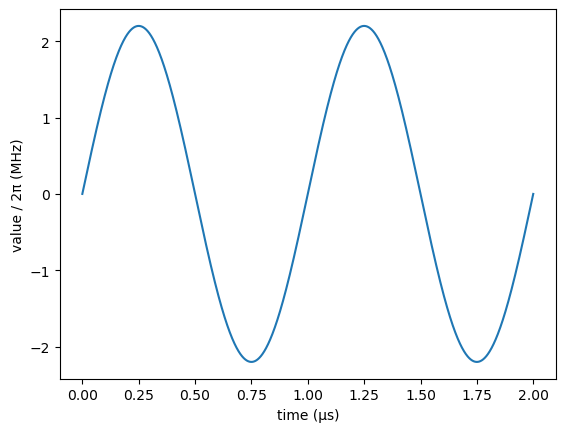

In [20]:
Bloqade.plot(smooth_ϕ)

The second value that's returned in the 1-norm difference between the original waveform and the new one

In [21]:
discretized_ϕ, _ =   hardware_transform_ϕ(smooth_ϕ)

(Waveform(_, 2.0), 1.8229936757103122)

Check out the discretization! Due to the hardware constraints, all Phase waveforms have to be piecewise constant, so the smooth waveform we saw earlier had to be discretized.

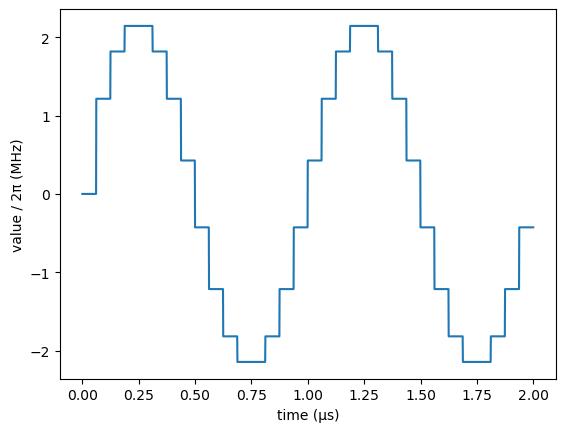

In [22]:
Bloqade.plot(discretized_ϕ)

What about a smooth Rabi Frequency waveform?

In [23]:
smooth_Ω = Waveform(t->(t^2-t)*2π, duration = 2);

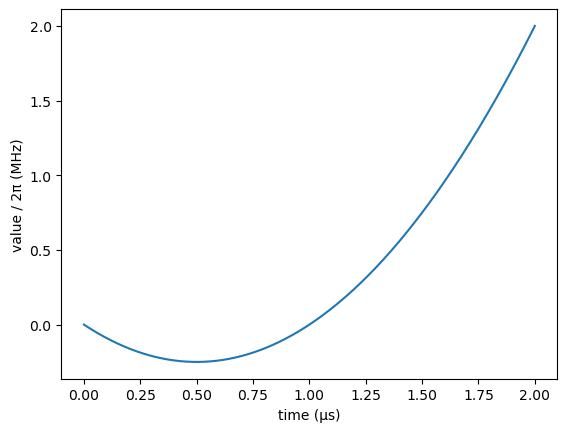

In [24]:
Bloqade.plot(smooth_Ω)

In [25]:
discretized_Ω, _ =   hardware_transform_Ω(smooth_Ω)

(Waveform(_, 2.0), 1.1942345489863697)

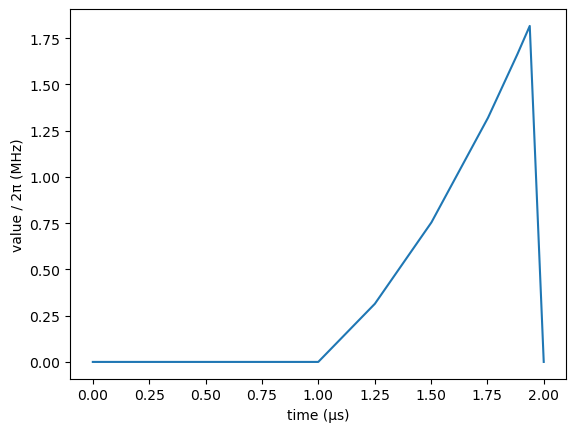

In [26]:
Bloqade.plot(discretized_Ω)

For both the Rabi Frequency and Detuning waveforms, they automatically get converted to piecewise linear instances.

Notice some additional constraints here:
* The starting and ending values of the Rabi Frequency waveform must be 0.0
* There is a maximum allowable slope or "slew rate" that has to be obeyed so the waveform cannot instantaneously change values
* In cases where the waveform exceeds the minimum or maximum it is automatically clipped to the closest boundary value (e.g. the waveform about seems to go into negative values and the closest to that is 0.0)

How are waveforms for the detuning transformed?

In [27]:
smooth_Δ = Waveform(t->2.2*2π*cos(4π*t), duration = 2);

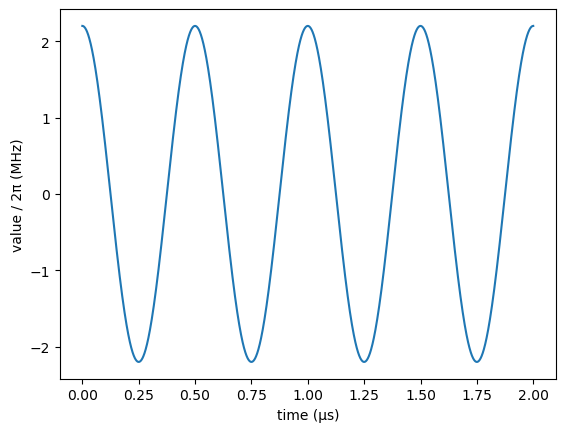

In [28]:
Bloqade.plot(smooth_Δ)

In [29]:
discretized_Δ, _ =   hardware_transform_Δ(smooth_Δ)

(Waveform(_, 2.0), 0.9694458348302721)

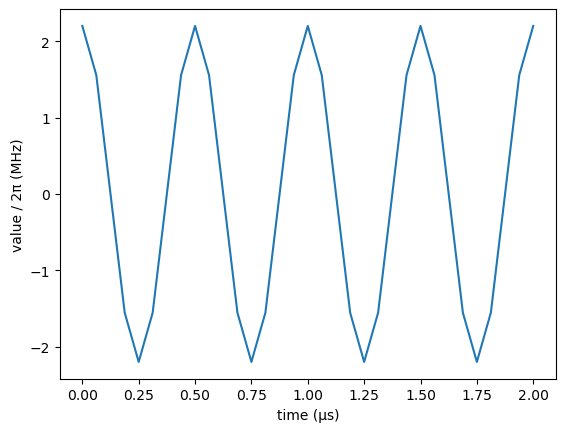

In [30]:
Bloqade.plot(discretized_Δ)

Note here the difference/similarity from the Rabi Frequency constraints:
* negative values are allowed (up to -125.0 rad/$\mu s$)
* The waveform does NOT have to start and end at 0.0
* There is still a maximum slew rate that has to be kept in mind

Finally, we can see how the `hardware_transform` affects atoms.

In [31]:
atom_positions = ((1.12,), (2.01,), (3.01,));
hardware_transform_atoms(atom_positions)

([(1.1,), (2.0,), (3.0,)], 0.013333333333333197)

Because of the restriction position resolution (smallest difference can be defined as 0.1), the atom positions in this 1D chain have to be rounded.

Note finally that a potentially important practice is to perform simulations and think algorithms using waveforms that are originally made out of piecewise linear or piecewise constant segments, and with atom positions defined within the experimental errors, thus minimizing the transformations applied to the original control channels when submitting jobs to the real quantum hardware.

## Validating our Hamiltonian

Now that we've transformed our Hamiltonian, we should be all set, right? 

A double-check is always helpful, particularly as there are certain constraints that `hardware_transform` will not attempt to satisfy that require direct user intervention because it is non-trivial as to what a corrected version might look like. A common one you might encounter is with regards to atom spacing. Currently, the following constraints are imposed on arbitrary atom geometries in terms of spacing:
* minimum radial spacing is 4.0 
* minimum vertical spacing is 4.0

If the spacing is violated, `hardware_transform` will not attempt to correct this but `validation` will catch it.

Before we show what this might look like, let's check that our current problem hamiltonian doesn't have other problems:

In [32]:
validate(transformed_h)

The following validation violations occured:



No output afterwards means no violations were found and we're ready to move onto the next step!

## Tweaking Your Hamiltonian

For pedagogical purposes let us see what happens if we feed something that fails validation and how to correct it. In this case we generate something that violates the atom spacing constraint:

In [33]:
# random waveforms
Δ =  Waveform(t->2.2*2π*sin(t)^2, duration=1.1);
Ω = linear_ramp(duration=1.1, start_value=0.0, stop_value=2π*1.0);
ϕ = constant(;duration=1.1, value=1.2*2π);

# atoms are way too close to each other!
problematic_atoms = generate_sites(ChainLattice(), 4, scale=1.0);

problematic_h = rydberg_h(problematic_atoms; Δ = Δ, Ω = Ω, ϕ = ϕ)

nqubits: 4
+
├─ [+] ∑ 2π ⋅ 8.627e5.0/|x_i-x_j|^6 n_i n_j
├─ [+] Ω(t) ⋅∑ e^{ϕ(t) ⋅ im} |0⟩⟨1| + e^{-ϕ(t) ⋅ im} |1⟩⟨0|
└─ [-] Δ(t) ⋅ ∑ n_i


In [34]:
transformed_problematic_h, _ = hardware_transform(problematic_h)

(nqubits: 4
+
├─ [+] ∑ 2π ⋅ 8.627e5.0/|x_i-x_j|^6 n_i n_j
├─ [+] Ω(t) ⋅∑ e^{ϕ(t) ⋅ im} |0⟩⟨1| + e^{-ϕ(t) ⋅ im} |1⟩⟨0|
└─ [-] Δ(t) ⋅ ∑ n_i
, BloqadeSchema.HardwareTransformInfo(8.293804605477055, 0.13983001873346415, 0.0072365283422223346, (Δ = Waveform(_, 1.1), δ = nothing, Δi = 1.0), 0.0))

In [35]:
validate(transformed_problematic_h)

The following validation violations occured:

1. positions 3 => (2.0, 0.0) and 4 => (3.0, 0.0) are a distance of 1.0 μm apart which is below minimum value of 4.0 μm
2. positions 2 => (1.0, 0.0) and 3 => (2.0, 0.0) are a distance of 1.0 μm apart which is below minimum value of 4.0 μm
3. positions 2 => (1.0, 0.0) and 4 => (3.0, 0.0) are a distance of 2.0 μm apart which is below minimum value of 4.0 μm
4. positions 1 => (0.0, 0.0) and 4 => (3.0, 0.0) are a distance of 3.0 μm apart which is below minimum value of 4.0 μm
5. positions 1 => (0.0, 0.0) and 2 => (1.0, 0.0) are a distance of 1.0 μm apart which is below minimum value of 4.0 μm
6. positions 1 => (0.0, 0.0) and 3 => (2.0, 0.0) are a distance of 2.0 μm apart which is below minimum value of 4.0 μm


Now we see that the atoms are too close to each other and need to be rescaled to a minimum distance of 4.0

In [36]:
fixed_atoms = generate_sites(ChainLattice(), 4, scale=4.0);

Let's plug the new atom geometry and construct a fixed Hamiltonian:

In [37]:
# we can reuse the waveforms defined before because they didn't cause any validation problems
fixed_h = rydberg_h(fixed_atoms; Δ = Δ, Ω = Ω, ϕ = ϕ)

nqubits: 4
+
├─ [+] ∑ 2π ⋅ 8.627e5.0/|x_i-x_j|^6 n_i n_j
├─ [+] Ω(t) ⋅∑ e^{ϕ(t) ⋅ im} |0⟩⟨1| + e^{-ϕ(t) ⋅ im} |1⟩⟨0|
└─ [-] Δ(t) ⋅ ∑ n_i


In [38]:
transformed_fixed_h, _ = hardware_transform(fixed_h)

(nqubits: 4
+
├─ [+] ∑ 2π ⋅ 8.627e5.0/|x_i-x_j|^6 n_i n_j
├─ [+] Ω(t) ⋅∑ e^{ϕ(t) ⋅ im} |0⟩⟨1| + e^{-ϕ(t) ⋅ im} |1⟩⟨0|
└─ [-] Δ(t) ⋅ ∑ n_i
, BloqadeSchema.HardwareTransformInfo(8.293804605477055, 0.13983001873346415, 0.0072365283422223346, (Δ = Waveform(_, 1.1), δ = nothing, Δi = 1.0), 0.0))

In [39]:

validate(transformed_fixed_h)

The following validation violations occured:



Now we see the validation error is gone.

## Submitting you Hamiltonian

Congratulations, you now have a Hardware compatible Hamiltonian! Finally, you can submit it to hardware. 

`BloqadeSchema` comes with the ability to do this, taking advantage of AWS's Julia packages to do so (chiefly `Braket.jl` and `AWS.jl`).

Before doing so, you'll need to obtain credentials for Amazon Braket. This can be found under "Command line or programmatic access" where you'll need:
* AWS Access Key ID
* AWS Secret Access Key
* AWS Session Token

If you have an AWS account that is *not configured for SSO (Single Sign-On)* you should only need to provide your Access Key Id and Secret Access Key (there is no session token).

These will be used to create an AWS Credentials object that will allow you to connect to the machine's queue.

In [ ]:
using AWS
access_key_id = "your_access_key_id"
secret_key = "your_secret_key"
token = "your_token"
credentials = AWS.AWSCredentials(access_key_id, secret_key, token)

*NOTE:* sometimes explicitly passing the credentials in may fail, in which case you can pass them in through setting the proper environment variables. Julia can access environment variables through an automatically defined `ENV` dictionary that can just add your credentials to. Then AWS will automatically use those values to create a credentials object. See the example below:

In [110]:
#=
using AWS
ENV["AWS_ACCESS_KEY_ID"] = "your_access_key_id"
ENV["AWS_SECRET_ACCESS_KEY"] = "your_secret_key"
ENV["AWS_SESSION_TOKEN"] = "your_session_token"
credentials = AWS.AWSCredentials(access_key_id, secret_key, token)
=#


With the credentials object created, we can now invoke `submit_to_braket` with our problem hamiltonian and the number of shots (times the Hamiltonian should be run on the machine).

In [ ]:
task = submit_to_braket(transformed_h, 10; credentials=credentials)

> NOTE: in the submission example above, we are setting the number of shots to `10` so as to make sure no one will spend non-negligible amounts of credits by mistake. To generate data that really provides good statistics to reproduce results from classical emulation on Bloqade, a few hundreds to a thousand shots may be necessary. Ultimately, this number depends on the algorithm and application in mind by the user.

Upon the creation of the task (a Hamiltonian that has been sent off to hardware) object, you should see a long string with a component along the lines of "taskArn:<alphanumeric-sequence-here>". The alphanumeric sequence uniquely identifies the task. Should your notebook crash or you'd like to access the results of the task later, you can use this ARN to recreate the task object as well as confirm the task is on Queue in the AWS Braket Web UI under the "Tasks" menu.

With the task submitted you may need to wait a bit as all tasks go onto a queue that the machine then consumes from in its open windows of operation (16:00 - 20:00 UTC on Tuesdays and Wednesdays, 16:00 - 18:00 UTC on Thursdays). You can check the status of your task using the `Braket.jl` library.


In [ ]:
using Braket
Braket.state(task)

## Retrieving Your Hamiltonian

Once the status has changed to "COMPLETED" you can now access the results via:

In [ ]:
res = Braket.result(task)

If you're more comfortable with the Python ecosystem for performing analysis, rest assured that you can save your results in JSON format and just use Python's default `json` library to render it as a dictionary object.

In [169]:
using JSON3

open("results.json", "w") do io
    JSON3.write(io, res)
end

92428

And in python you can follow up with:

```python
import json
with open("results.json", "r") as f:
    data = json.load(f)

# two main keys, "measurements" and "metadata"
measurements = data["measurements"]

# each measurement has an associated "pre_sequence" key, indicating that the atoms were loaded properly
# a "post_sequence" which indicates the actual measurement, and a "status" indicating the success of that particular measurement
for measurement in measurements:
    print(measurement["post_sequence"])
```

We can perform some analysis directly on the `AnalogHamiltonianSimulationQuantumTaskResult` with the same density plotting function but a different function for calculationg the rydberg_density that works directly on such objects.

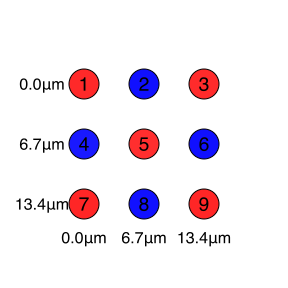

In [156]:
plot_densities(atoms, BloqadeSchema.rydberg_density(res))

We see that the hardware results agree quite well with simulation! Granted this may not have been the case if we had reduced the number of shots, owing to noise and quality of waveform choices. 

# Storing Your Hamiltonian/Task

It may be useful in certain scenarios to have the ability to store the Hamiltonian in a format suitable for submission later.

This can be done with `BloqadeSchema` and the `JSON3` package, which is separate from Bloqade:

In [ ]:
using JSON3
# provide device capabilities and number of shots as parameters
device_capabilities = BloqadeSchema.get_device_capabilities()
nshots = 100
translation_params = BloqadeSchema.SchemaTranslationParams(nshots, device_capabilities)

# Convert to QuEraTaskSpecification format
bloqade_ir = BloqadeSchema.to_dict(transformed_h, translation_params)
# Save to file
open("my_task.json", "w") do io
    JSON3.pretty(io, bloqade_ir)
end

If you ever receive results as a JSON file they can be opened in Julia for further analysis like so:

```julia
results_string = read("result.json", String)

results_dict = JSON3.read(results_string, Dict)
```

## Conclusion

You should now be comfortable with the pipeline for designing and submitting custom problems to Aquila. You're well on your way to becoming a neutral atom master!